# Hw 3

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import math

%matplotlib inline

Import Data

In [2]:
def get_data(token):
    if token == 'FLOW':
        exchange = 'kraken'
    else:
        exchange = 'coinbase-pro'
    res = requests.get(
        f'https://api.cryptowat.ch/markets/{exchange}/{token}usd/ohlc',
        params={
            'periods': '3600',
            'after': str(int(pd.Timestamp('2021-11-22').timestamp()))
        }
    )

    df = pd.DataFrame(
        res.json()['result']['3600'],
        columns=['ts', 'open', 'high', 'low', 'close', 'volume', 'volumeUSD']
    )
    df['ts'] = pd.to_datetime(df.ts, unit='s')
    df['token'] = token
    
    return df


In [3]:
tokens = ['ETH', 'SOL', 'AVAX', 'USDT', 'FLOW']

In [4]:
data = [get_data(token) for token in tokens]

In [5]:
df = pd.concat(data).sort_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3740 entries, 0 to 747
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ts         3740 non-null   datetime64[ns]
 1   open       3740 non-null   float64       
 2   high       3740 non-null   float64       
 3   low        3740 non-null   float64       
 4   close      3740 non-null   float64       
 5   volume     3740 non-null   float64       
 6   volumeUSD  3740 non-null   float64       
 7   token      3740 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 263.0+ KB


Get the total USD volume traded for each token in a dataframe, sorted from highest volume to lowest volume

In [6]:
df

,ts,open,high,low,close,volume,volumeUSD,token
0,2021-11-22 00:00:00,4317.9800,4342.2400,4246.0700,4262.9900,7.262563e+03,3.123077e+07,ETH
0,2021-11-22 00:00:00,131.6900,133.7900,127.7000,128.6700,9.686748e+04,1.267080e+07,AVAX
0,2021-11-22 00:00:00,13.8870,14.1690,13.8870,14.1500,2.326138e+04,3.274755e+05,FLOW
0,2021-11-22 00:00:00,230.4830,234.6880,228.8050,230.7850,9.353180e+04,2.172284e+07,SOL
0,2021-11-22 00:00:00,1.0010,1.0017,1.0009,1.0012,9.987681e+06,9.999090e+06,USDT
...,...,...,...,...,...,...,...,...
747,2021-12-23 03:00:00,1.0005,1.0005,1.0004,1.0004,3.264710e+05,3.266107e+05,USDT
747,2021-12-23 03:00:00,180.1600,180.3300,179.3700,180.0200,8.336744e+03,1.498720e+06,SOL
747,2021-12-23 03:00:00,3956.2200,3956.2200,3946.2900,3953.4900,2.102662e+02,8.304627e+05,ETH
747,2021-12-23 03:00:00,121.9100,122.1800,121.3100,122.1300,8.595436e+03,1.045941e+06,AVAX


In [7]:
dfbytoken = df.groupby(['token'])
# dir(dfbytoken)

In [8]:
VUSDperToken = dfbytoken['volumeUSD'].sum().sort_values(ascending=False).to_frame()
VUSDperToken

,volumeUSD
token,
ETH,2.685634e+10
SOL,8.898821e+09
AVAX,5.003837e+09
USDT,2.459491e+09
FLOW,1.021546e+08


Add a column that calculates the close price ratio between ETH and SOL for each house (i.e. close price of ETH / close price of SOL for each period)

In [9]:
ratioES = dfbytoken.get_group('ETH').set_index('ts')['close'] / dfbytoken.get_group('SOL').set_index('ts')['close']
ratioES.name = 'ratioES'
ratioES = ratioES.to_frame()
ratioES

,ratioES
ts,
2021-11-22 00:00:00,18.471694
2021-11-22 01:00:00,18.736150
2021-11-22 02:00:00,18.577985
2021-11-22 03:00:00,18.794937
2021-11-22 04:00:00,18.891059
...,...
2021-12-22 23:00:00,22.063492
2021-12-23 00:00:00,22.309442
2021-12-23 01:00:00,22.168251


In [10]:
dfratioES = df.join(ratioES, on = 'ts')
dfratioES

,ts,open,high,low,close,volume,volumeUSD,token,ratioES
0,2021-11-22 00:00:00,4317.9800,4342.2400,4246.0700,4262.9900,7.262563e+03,3.123077e+07,ETH,18.471694
0,2021-11-22 00:00:00,131.6900,133.7900,127.7000,128.6700,9.686748e+04,1.267080e+07,AVAX,18.471694
0,2021-11-22 00:00:00,13.8870,14.1690,13.8870,14.1500,2.326138e+04,3.274755e+05,FLOW,18.471694
0,2021-11-22 00:00:00,230.4830,234.6880,228.8050,230.7850,9.353180e+04,2.172284e+07,SOL,18.471694
0,2021-11-22 00:00:00,1.0010,1.0017,1.0009,1.0012,9.987681e+06,9.999090e+06,USDT,18.471694
...,...,...,...,...,...,...,...,...,...
747,2021-12-23 03:00:00,1.0005,1.0005,1.0004,1.0004,3.264710e+05,3.266107e+05,USDT,21.961393
747,2021-12-23 03:00:00,180.1600,180.3300,179.3700,180.0200,8.336744e+03,1.498720e+06,SOL,21.961393
747,2021-12-23 03:00:00,3956.2200,3956.2200,3946.2900,3953.4900,2.102662e+02,8.304627e+05,ETH,21.961393
747,2021-12-23 03:00:00,121.9100,122.1800,121.3100,122.1300,8.595436e+03,1.045941e+06,AVAX,21.961393


Change the name of the `volume` and `volumeUSD` columns to `volumeBase` and `volumeTerm`

In [11]:
dfnamechange = df.rename(columns = {'volume': 'volumeBase', 'volumeUSD': 'volumeTerm'})
dfnamechange

,ts,open,high,low,close,volumeBase,volumeTerm,token
0,2021-11-22 00:00:00,4317.9800,4342.2400,4246.0700,4262.9900,7.262563e+03,3.123077e+07,ETH
0,2021-11-22 00:00:00,131.6900,133.7900,127.7000,128.6700,9.686748e+04,1.267080e+07,AVAX
0,2021-11-22 00:00:00,13.8870,14.1690,13.8870,14.1500,2.326138e+04,3.274755e+05,FLOW
0,2021-11-22 00:00:00,230.4830,234.6880,228.8050,230.7850,9.353180e+04,2.172284e+07,SOL
0,2021-11-22 00:00:00,1.0010,1.0017,1.0009,1.0012,9.987681e+06,9.999090e+06,USDT
...,...,...,...,...,...,...,...,...
747,2021-12-23 03:00:00,1.0005,1.0005,1.0004,1.0004,3.264710e+05,3.266107e+05,USDT
747,2021-12-23 03:00:00,180.1600,180.3300,179.3700,180.0200,8.336744e+03,1.498720e+06,SOL
747,2021-12-23 03:00:00,3956.2200,3956.2200,3946.2900,3953.4900,2.102662e+02,8.304627e+05,ETH
747,2021-12-23 03:00:00,121.9100,122.1800,121.3100,122.1300,8.595436e+03,1.045941e+06,AVAX


create a fat table indexed by the timestamp, and each column is the close price of each token (i.e. this should be a table of  200 rows and 5 columns)

In [12]:
dfFat = df.reset_index().pivot(index='ts',columns='token',values='close')
dfFat

token,AVAX,ETH,FLOW,SOL,USDT
ts,,,,,
2021-11-22 00:00:00,128.67,4262.99,14.150,230.785,1.0012
2021-11-22 01:00:00,134.85,4234.37,13.621,226.000,1.0013
2021-11-22 02:00:00,132.54,4217.89,13.753,227.037,1.0012
2021-11-22 03:00:00,133.38,4193.47,13.652,223.117,1.0011
2021-11-22 04:00:00,136.29,4168.35,13.581,220.652,1.0009
...,...,...,...,...,...
2021-12-22 23:00:00,119.90,4003.20,8.553,181.440,1.0004
2021-12-23 00:00:00,116.66,3981.12,8.489,178.450,1.0002
2021-12-23 01:00:00,121.00,3942.18,8.825,177.830,1.0002


calculate the hour by hour log return of the close price of each token (return is calculated by np.log(price_t / price_{t-1}))

In [13]:
dfReturn = np.log(dfFat)
dfReturn = dfReturn.diff()
dfReturn

token,AVAX,ETH,FLOW,SOL,USDT
ts,,,,,
2021-11-22 00:00:00,NaN,NaN,NaN,NaN,NaN
2021-11-22 01:00:00,0.046912,-0.006736,-0.038102,-0.020952,0.0001
2021-11-22 02:00:00,-0.017279,-0.003900,0.009644,0.004578,-0.0001
2021-11-22 03:00:00,0.006318,-0.005806,-0.007371,-0.017417,-0.0001
2021-11-22 04:00:00,0.021583,-0.006008,-0.005214,-0.011109,-0.0002
...,...,...,...,...,...
2021-12-22 23:00:00,-0.007975,-0.003075,-0.003967,-0.000937,0.0001
2021-12-23 00:00:00,-0.027394,-0.005531,-0.007511,-0.016617,-0.0002
2021-12-23 01:00:00,0.036527,-0.009829,0.038817,-0.003480,0.0000


\[Stretch\] calculate the correlation of the tokens using the table above

In [14]:
dfcorr = dfReturn.corr()
dfcorr

token,AVAX,ETH,FLOW,SOL,USDT
token,,,,,
AVAX,1.000000,0.654649,0.411869,0.645254,0.020910
ETH,0.654649,1.000000,0.570816,0.757113,-0.081278
FLOW,0.411869,0.570816,1.000000,0.472898,-0.172064
SOL,0.645254,0.757113,0.472898,1.000000,0.106704
USDT,0.020910,-0.081278,-0.172064,0.106704,1.000000


\[Stretch\] visualize the correlation in a matplpotlib plot

<Figure size 432x288 with 0 Axes>

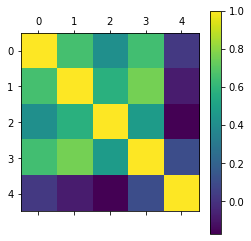

In [15]:
fig = plt.figure()
plt.matshow(dfcorr)
cb = plt.colorbar()